#### Explore AI Academy: Unsupervised Learning Project



<div style="font-size: 35px">
    <font color='Maroon'> <b>Anime Recommender System Project</b></font> 

![anime_collage](image.png)



## Table of Contents

<a id = "cont"></a>

[1. Project Objective ](#1.-Project-Objective )

[2. Importing Packages](#2.-Importing-Packages)

[3. Loading Data](#3.-Loading-Data)

[4. Data Cleaning](#4.-Data-Cleaning)

[5. Exploratory Data Analysis (EDA)](#5.-Exploratory-Data-Analysis-(EDA))

[6. Modelling](#6.-Modelling)

- [6.1 Content Based Filtering](#6.1-Content-Based-Filtering)
- [6.2 Collaborative Filtering](#6.2-Collaborative-Filtering)

[7. Model Performance](#7.-Model-Performance)

[8. Streamlit](#8.-Streamlit)

[9. Conclusion](#9.-Conclusion)



## 1. Project Objective 


> The objective of this project is ti Build a collaborative and content-based recommender system for a collection of anime titles, capable 
of accurately predicting how a user will rate an anime title they have not yet viewed, based on their 
historical preferences.


## 2. Importing Packages

In [22]:
# Libraries for data loading, manipulation and analysis

import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# Displays output inline
%matplotlib inline

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

import operator # <-- Convenient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Libraries for Handing Errors
import warnings
warnings.filterwarnings('ignore')

# displays unlimited number of columns
pd.set_option("display.max_columns", 100)



## 3. Loading Data 

The complete anime data used for this project was located in the `anime.csv` file. The data in `train.csv` contains the users and ther anime IDs and ratings. We use this to create the utility matrix and a sample to test the performance of the filters.

##### Anime data

In [23]:
# loading dataset
df = pd.read_csv("anime.csv", index_col=False)
df.head()
anime = df.copy()
# Displays the number of rows and columns
anime.shape

(12294, 7)

In [24]:
## Display summary information about the DataFrame.
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [25]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


##### Training data

In [26]:
#training data
df = pd.read_csv("train.csv", index_col=False)
train = df.copy()
train.shape

(5703555, 3)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703555 entries, 0 to 5703554
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 130.5 MB


In [28]:
train.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [29]:
train.head()

,user_id,anime_id,rating
0,1,11617,10
1,1,11757,10
2,1,15451,10
3,2,11771,10
4,3,20,8


The dataset consists of 12294 rows of different anime title. There are null in aniem data, training/ user data seems to be well populated with no null, we will check for duplicates.

## 4. Data Cleaning

**Check nulls**

The `check_null_values` function iterates over each column in a DataFrame to identify and print the count of null values, providing column-specific null counts.

In [31]:
def check_null_values(df_copy):
    for column in df_copy:
        if df_copy[column].isnull().any():
            print('{0} has {1} null values'.format(column, df_copy[column].isnull().sum()))

In [32]:
check_null_values(anime)

genre has 62 null values
type has 25 null values
rating has 230 null values


In [33]:
anime = anime.dropna() 
anime = anime.reset_index(drop=True) 

In [34]:
anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

About 277 null rows have been deleted

**Duplicates**

The `count_duplicate_rows` function checks a DataFrame for duplicate entries by utilizing the duplicated method, which identifies duplicates, and then summarizes the total number of duplicate rows. This function is useful for data cleaning processes, ensuring uniqueness in datasets by returning the count of duplicate rows.

In [35]:
def count_duplicate_rows(df_copy):
    duplicate_count = df_copy.duplicated().sum()
    return duplicate_count


In [36]:
count_duplicate_rows(anime)

np.int64(0)

In [37]:
count_duplicate_rows(train)

#one duplicate, remove

np.int64(1)

**Remove noise**

Initial we though to remvove punctuations and numbers from the data, but this causes errors down the line. We only trim the leading and training spaces.

In [38]:
def remove_numbers_punctuation(text):
    # Remve numbers
    #text = re.sub(r'\d+', '', text)
    # Remove punctuation
    #text = re.sub(r'[^\w\s]', '', text)

    text = text.strip()
    return text

In [39]:
import re
anime['name'] = anime['name'].apply(remove_numbers_punctuation)
train = pd.merge(train, anime[['anime_id','name']], on = 'anime_id', how ='left')
train = train.dropna() 
train = train.reset_index(drop=True) 

In [40]:
train.isna().sum()

user_id     0
anime_id    0
rating      0
name        0
dtype: int64

## 5. Exploratory Data Analysis (EDA) 


To give a better understanding of the variables and the relationships between them, we set out to do an **Exploratory Data Analysis (EDA)** of our dataset. The main tasks includes investigating and summarizing the dataframe's main characteristics by data visualization methods and statistical analyses. Furthermore, investigating the dataset’s key features, summarizing its central characteristics, and employing both data visualisation techniques and statistical analyses to draw meaningful insights that can guide further research and data-driven decision making.
 

---

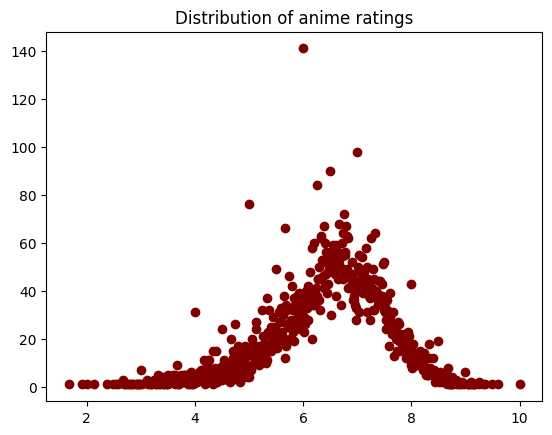

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

x = anime.groupby('rating').count().reset_index()[['rating','anime_id']]
x.head()
plt.scatter(x.rating,x.anime_id,color = 'Maroon')
#sns.catplot(data=train, x="rating", y=None, aspect=2.0, kind='count')
#plt.hist(x.rating, bins=10)
#sns.kde(x.rating
plt.title('Distribution of anime ratings')
plt.show()
#distribution of ratings

Average rating in dataset: 7.808690544756735


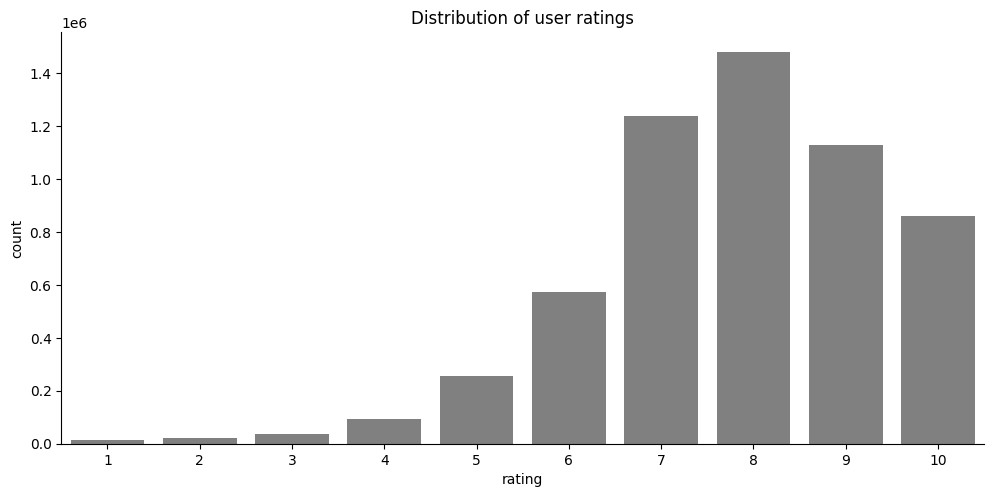

In [54]:
sns.catplot(data=train, x="rating", y=None, aspect=2.0, kind='count', color = 'gray')
print(f'Average rating in dataset: {np.mean(df["rating"])}')
plt.title("Distribution of user ratings")
plt.show()

### 6. Modelling

#### 6.1 Content Based Filtering

Merge anime name and genre description for completeness, so that if generes are different but names are similar that too is consiered whne computing the simularity score

In [55]:
anime['tags'] = (pd.Series(anime[['name', 'genre']]
                      .fillna('')
                      .values.tolist()).str.join(', '))

In [56]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members,tags
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"Kimi no Na wa., Drama, Romance, School, Supern..."
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"Fullmetal Alchemist: Brotherhood, Action, Adve..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"Gintama°, Action, Comedy, Historical, Parody, ..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"Steins;Gate, Sci-Fi, Thriller"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,"Gintama&#039;, Action, Comedy, Historical, Par..."


In [57]:
indices = pd.Series(anime.index, index=anime['name'])

In [58]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tf_authTags_matrix = tf.fit_transform(anime['tags'])

In [59]:
cosine_sim_Tags = cosine_similarity(tf_authTags_matrix, 
                                        tf_authTags_matrix)
print (cosine_sim_Tags.shape)

(12017, 12017)


In [60]:
cosine_sim_Tags

array([[1.        , 0.0132023 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0132023 , 1.        , 0.02487266, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02487266, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.55027311,
        0.01853217],
       [0.        , 0.        , 0.        , ..., 0.55027311, 1.        ,
        0.01441356],
       [0.        , 0.        , 0.        , ..., 0.01853217, 0.01441356,
        1.        ]])

**Rating estimation functions**

In [61]:
def content_generate_rating_estimate(title, user, rating_data, k=10, threshold=0.0):
    # Convert the book title to a numeric index for our 
    # similarity matrix
    #print(title)
    b_idx = indices[title]
    #print(b_idx)
    neighbors = [] # <-- Stores our collection of similarity values 
     
    # Gather the similarity ratings between each book the user has rated
    # and the reference book 
    for index, row in rating_data[rating_data['user_id']==user].iterrows():
        #print(row['name'])
        #print(b_idx-1, indices[row['name']]-1)
        sim = cosine_sim_Tags[b_idx-1, indices[row['name']]-1]
        neighbors.append((sim, row['rating']))
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and 
    # user item ratings. 
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user. 
        # We use the average rating for the reference item as a proxy in this case 
        predictedRating = np.mean(rating_data[rating_data['name']== title]['rating'])
    return predictedRating

**Testing**

In [62]:
# Subset of ratings from user 314
data = train[train['user_id'] == 3]
#data = pd.merge(data, anime[['anime_id','name']], on = 'anime_id', how ='left')
data

,user_id,anime_id,rating,name
4,3,20,8,Naruto
5,3,170,9,Slam Dunk
6,3,199,10,Sen to Chihiro no Kamikakushi
7,3,225,9,Dragon Ball GT
8,3,341,6,Spiral: Suiri no Kizuna
...,...,...,...,...
84,3,28701,9,Fate/stay night: Unlimited Blade Works 2nd Season
85,3,28891,9,Haikyuu!! Second Season
86,3,29854,6,Ushio to Tora (TV)
87,3,31043,10,Boku dake ga Inai Machi


In [63]:
title = "Naruto"
actual_rating = data[(data['user_id'] == 3) & (data['name'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(title=title, user=314, rating_data=data)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Naruto
---
Actual rating: 		 8
Predicted rating: 	 8.0


#### 6.2 Collaborative Filtering

Data too large, had to shrink it for memory, we retain the users with the most ratings to ensure most infromation is retained

In [64]:
# Filter users with at least 3 ratings
user_counts = train['user_id'].value_counts()
active_users = user_counts [user_counts  >= 46].index
train_shrinked = train[train['user_id'].isin(active_users)]

#print(train_shrinked)


In [65]:
train_shrinked= train_shrinked.reset_index(drop=True) 

In [66]:
util_matrix = train_shrinked.pivot_table(index=['user_id'], 
                                       columns=['name'],
                                       values='rating') 
util_matrix.shape

(32599, 9789)

In [67]:
# Normalize each row (a given user's ratings) of the utility matrix
import scipy as sp
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [68]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_norm.columns, 
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix  
user_sim_df[:5]

user_id,3,5,7,11,14,17,21,23,24,27,29,31,37,38,39,40,41,43,44,46,48,50,51,52,62,66,71,73,75,77,79,80,81,87,93,95,98,99,102,104,106,107,108,109,111,112,120,122,123,125,...,73397,73398,73400,73404,73406,73408,73413,73414,73415,73416,73417,73420,73422,73424,73426,73427,73428,73431,73432,73437,73439,73440,73442,73443,73449,73453,73457,73458,73460,73462,73463,73470,73474,73476,73478,73480,73483,73485,73490,73494,73495,73499,73500,73501,73502,73503,73504,73507,73510,73515
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.054259,0.162695,0.049089,-0.012660,0.168410,0.057113,0.013048,0.050693,0.040545,0.030901,0.037963,0.027656,0.052370,-0.009038,0.003135,-0.064437,0.019151,0.038386,0.100383,-0.002401,0.003655,0.020679,0.048257,0.110495,0.004624,0.058720,0.079083,0.065656,0.042861,0.041795,0.083388,-0.047950,0.125389,-0.006979,0.045440,0.079572,-0.017313,0.060802,0.057102,0.072367,0.016809,0.005754,-0.022687,-0.012477,0.009865,0.043834,0.012848,0.129485,-0.007498,...,0.043800,0.067110,0.013587,0.005892,0.029438,0.008087,0.009269,0.062587,0.056780,0.006685,-0.002367,0.053595,0.018138,0.021425,-0.006800,0.053745,0.004774,-0.022118,0.036289,0.057226,0.000000,0.027667,0.007468,0.028946,0.038163,0.035696,0.022909,0.010753,0.009742,-0.003460,0.043296,0.035945,0.016142,0.064449,0.036630,0.019879,0.034336,0.028948,0.060371,0.013607,0.025803,0.079002,0.036228,0.008497,0.006654,0.046271,0.004680,0.012779,0.049307,0.046265
5,0.054259,1.000000,0.085513,0.028753,0.128188,0.127079,0.043819,0.046176,-0.008117,-0.037422,0.143778,0.010776,0.069701,0.172410,-0.024559,0.030938,-0.006072,0.056115,0.019431,0.087231,0.026547,0.026728,0.021966,0.026953,0.042081,-0.023224,0.064101,0.050697,0.006814,0.080818,0.094208,0.037202,0.072512,0.038467,0.086399,-0.072643,-0.003830,0.108760,0.037806,-0.036144,0.020319,0.005273,0.049837,0.008264,0.050026,0.007877,0.031727,-0.059453,0.061383,0.043585,...,-0.016588,-0.006733,0.019971,0.038316,0.082704,0.003921,0.034638,0.087091,0.072757,0.019181,-0.017296,0.076804,0.011973,0.058189,0.050434,0.050693,0.032329,-0.019893,0.075130,-0.013751,-0.015148,0.014947,-0.004651,0.031496,0.046690,0.067415,0.048365,0.060665,0.067088,0.063244,0.009114,-0.009723,0.077740,0.068551,0.032853,0.081787,0.044072,0.036891,-0.000590,-0.022492,-0.003369,0.098026,-0.002315,-0.036976,0.022518,0.084068,0.015738,0.066545,0.019796,0.044244
7,0.162695,0.085513,1.000000,-0.022596,0.076354,0.118253,0.089506,0.030809,-0.011535,0.036816,0.058106,-0.006542,0.021766,0.131822,0.033334,0.009098,-0.044979,0.012250,0.014549,0.014550,0.023889,0.063710,0.037170,0.052525,0.026983,0.006097,0.011791,0.012313,0.046830,0.020182,0.009820,0.063482,0.005759,0.008472,0.030672,0.019891,0.009951,0.070826,0.079906,0.059939,0.024666,0.026723,0.057601,-0.001924,0.056277,0.006176,0.073894,-0.055451,0.014718,-0.024099,...,0.030599,0.002801,0.009668,0.015620,0.053003,-0.007806,0.000481,0.068999,0.052201,0.089116,0.082383,-0.003560,0.043418,0.046555,0.006631,0.029441,0.017240,0.061179,0.007084,0.031957,-0.007915,0.051323,0.010943,0.020006,0.045787,0.027550,0.028271,0.057964,0.042750,-0.004632,0.008886,0.008508,0.042738,0.080358,-0.007734,0.069104,-0.000132,0.001026,0.020510,0.046514,0.066711,0.046280,0.051099,0.009686,0.074353,0.032527,0.010885,0.016726,0.053429,0.048959
11,0.049089,0.028753,-0.022596,1.000000,-0.013600,0.010317,0.044208,-0.063488,-0.009082,0.005873,-0.001770,0.007567,0.035388,0.026393,0.008462,-0.010790,0.018574,0.013579,0.013855,0.014223,0.030523,0.048599,0.113546,-0.011410,0.081165,0.035312,-0.036329,0.107210,0.020308,0.034511,0.012240,0.059723,0.076010,0.053777,0.010698,0.007851,0.015206,-0.023452,0.071488,0.046002,0.010473,-0.090353,-0.046104,0.015445,0.068472,0.036947,0.027407,0.020513,0.030852,0.039128,...,0.068202,0.063428,-0.020733,0.024217,-0.017757,0.038272,0.019047,0.045461,0.061868,-0.011230,-0.018979,0.027971,-0.000837,0.086758,0.025002,0.008079,0.001657,-0.035757,0.065531,0.029028

**Recommedation system**

In [71]:
import numpy as np
import pandas as pd

def collab_generate_rating_estimate(title, user, k=20, threshold=0.0):
    # Gather the k users most similar to the reference user
    #print('Gather the k users most similar to the reference user')
    
    # Sort the similarity values once and fetch the k most similar users and their similarity values
    sorted_sim_users = user_sim_df[user].sort_values(ascending=False).iloc[1:k+1]
    
    # Get the user IDs and their corresponding similarity values
    sim_users = sorted_sim_users.index
    user_values = sorted_sim_users.values
    
    # Extract ratings for the book title (avoiding repeated lookups)
    ratings = util_matrix.loc[sim_users, title].values
    
    # Filter out invalid ratings (NaN or below threshold) and compute weighted sum
    #print(f'Create weighted sum for each of the {len(sim_users)} users who have rated the item.')
    
    # Mask to filter out users with NaN ratings or similarity below threshold
    valid_mask = ~np.isnan(ratings) & (user_values >= threshold)
    
    # Apply mask to ratings and similarities
    valid_ratings = ratings[valid_mask]
    valid_similarities = user_values[valid_mask]
    
    # Calculate weighted sum
    if valid_ratings.size > 0:  # Ensure there are valid ratings
        weighted_sum = np.sum(valid_ratings * valid_similarities)
        total_weight = np.sum(valid_similarities)
        
        # Return the predicted rating as weighted average
        predicted_rating = weighted_sum / total_weight
    else:
        # If no valid ratings, return the average rating for the book
        print('No valid ratings found, returning average rating for the item.')
        predicted_rating = np.mean(util_matrix[title].dropna())
    
    return predicted_rating


**Testing**

In [73]:
title = "Naruto"
actual_rating = train_shrinked[(train_shrinked['user_id'] == 3) & (train_shrinked['name'] == title)]['rating'].values[0]
pred_rating = collab_generate_rating_estimate(title,3)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Title - Naruto
---
Actual rating: 		 8
Predicted rating: 	 8.4926627182628


Content based had a more accurate predicted rating, but this is only one example out of many, below we test the peformance of both model on a large sample of data

### 7. Model Performance

In [83]:
#Test performance of each method 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
from sklearn.metrics import mean_squared_error, root_mean_squared_error


#load test data 
#df = pd.read_csv("test.csv", index_col=False)
#test = df.copy()
#test.shape
test= train_shrinked.copy()
#test = pd.merge(data, anime[['anime_id','name']], on = 'anime_id', how ='left')
#test.dropna(inplace= True)
test['id'] = test[['anime_id', 'user_id']].fillna('').astype(str).agg('_'.join, axis=1)



In [75]:
test_sample = test.sample(100) 
test_sample = test_sample[test_sample.user_id.isin(np.array(user_sim_df.index))]
test_sample_id = np.array(test_sample['id'])
# Sample unique numbers 
#sampled_numbers = np.array(pd.Series(unique_numbers).sample(10))
#test_sample = test[test['id'].isin(test_sample_id)]
data = test[test['user_id'].isin(np.array(test_sample['user_id']))]


In [84]:
from tqdm import trange
import time 

def content_function(test_sample):
    test_sample['predicted_rating']=0
    time_list = []
    for i in trange(len(test_sample)):
        # Subset of ratings from user 314
        title = test_sample.iloc[i]['name']
        user =  test_sample.iloc[i]['user_id']
        data = train_shrinked[train_shrinked['user_id'] == test_sample.iloc[i]['user_id']]
        start_time = time.time()  
        test_sample.loc[test_sample.id == test_sample.iloc[i]['id'],'predicted_rating'] = content_generate_rating_estimate(title=title, user=user, rating_data=data)
        end_time = time.time() 
        duration = end_time - start_time
        time_list.append(duration)
        rmse = root_mean_squared_error(test_sample['rating'], test_sample['predicted_rating'])
    return rmse, np.sum(time_list)/100

In [86]:
from tqdm import trange

def collab_function(test_sample):
    test_sample['predicted_rating_collab']=0
    time_list = []
    for i in trange(len(test_sample)):
        # Subset of ratings from user 314
        title = test_sample.iloc[i]['name']
        user =  test_sample.iloc[i]['user_id']
        #data = train[train['user_id'] == test_sample.iloc[i]['user_id']]
        start_time = time.time()  
        test_sample.loc[test_sample.id == test_sample.iloc[i]['id'],'predicted_rating_collab'] = collab_generate_rating_estimate(title,user)
        end_time = time.time() 
        duration = end_time - start_time
        time_list.append(duration)
        rmse = root_mean_squared_error(test_sample['rating'], test_sample['predicted_rating_collab'])
    return rmse, np.sum(time_list)/100

In [88]:

rmse_content = []
time_content = []
rmse_collab = []
time_collab = []

for i in range(5):
    test_sample = test.sample(100) 
    test_sample = test_sample[test_sample.user_id.isin(np.array(user_sim_df.index))]
    test_sample_id = np.array(test_sample['id'])

    data = test[test['user_id'].isin(np.array(test_sample['user_id']))]
    rmse, timme = content_function(test_sample)
    rmse_content.append(rmse)
    time_content.append(timme)
    
    rmse, timme = collab_function(test_sample)
    rmse_collab.append(rmse)
    time_collab.append(timme)

    


    


  3%|██▌                                                                                | 3/99 [00:32<16:35, 10.37s/it]

No valid ratings found, returning average rating for the item.


 13%|██████████▊                                                                       | 13/99 [01:07<07:13,  5.04s/it]

No valid ratings found, returning average rating for the item.


 21%|█████████████████▍                                                                | 21/99 [01:40<06:30,  5.00s/it]

No valid ratings found, returning average rating for the item.


 25%|████████████████████▋                                                             | 25/99 [01:55<04:38,  3.76s/it]

No valid ratings found, returning average rating for the item.


 35%|████████████████████████████▉                                                     | 35/99 [02:39<05:13,  4.90s/it]

No valid ratings found, returning average rating for the item.


 37%|██████████████████████████████▋                                                   | 37/99 [02:39<02:37,  2.53s/it]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


 38%|███████████████████████████████▍                                                  | 38/99 [02:45<03:35,  3.53s/it]

No valid ratings found, returning average rating for the item.


 49%|████████████████████████████████████████▌                                         | 49/99 [03:35<05:04,  6.08s/it]

No valid ratings found, returning average rating for the item.


 53%|███████████████████████████████████████████                                       | 52/99 [03:47<03:26,  4.39s/it]

No valid ratings found, returning average rating for the item.


 54%|███████████████████████████████████████████▉                                      | 53/99 [03:55<04:13,  5.50s/it]

No valid ratings found, returning average rating for the item.


 59%|████████████████████████████████████████████████                                  | 58/99 [04:08<01:57,  2.86s/it]

No valid ratings found, returning average rating for the item.


 74%|████████████████████████████████████████████████████████████▍                     | 73/99 [04:43<00:49,  1.89s/it]

No valid ratings found, returning average rating for the item.


 84%|████████████████████████████████████████████████████████████████████▋             | 83/99 [04:54<00:20,  1.26s/it]

No valid ratings found, returning average rating for the item.


 90%|█████████████████████████████████████████████████████████████████████████▋        | 89/99 [05:05<00:14,  1.47s/it]

No valid ratings found, returning average rating for the item.


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [05:40<00:00,  3.44s/it]


No valid ratings found, returning average rating for the item.


 11%|████████▉                                                                        | 11/100 [00:21<02:03,  1.38s/it]

No valid ratings found, returning average rating for the item.


 13%|██████████▌                                                                      | 13/100 [00:24<02:00,  1.38s/it]

No valid ratings found, returning average rating for the item.


 21%|█████████████████                                                                | 21/100 [00:42<02:17,  1.74s/it]

No valid ratings found, returning average rating for the item.


 23%|██████████████████▋                                                              | 23/100 [00:48<02:43,  2.13s/it]

No valid ratings found, returning average rating for the item.


 46%|█████████████████████████████████████▎                                           | 46/100 [01:38<02:18,  2.57s/it]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:47<01:56,  2.39s/it]

No valid ratings found, returning average rating for the item.


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:55<01:31,  2.03s/it]

No valid ratings found, returning average rating for the item.


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:58<00:44,  1.08s/it]

No valid ratings found, returning average rating for the item.


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:00<00:44,  1.14s/it]

No valid ratings found, returning average rating for the item.


 63%|███████████████████████████████████████████████████                              | 63/100 [02:10<01:54,  3.09s/it]

No valid ratings found, returning average rating for the item.


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:18<02:38,  4.41s/it]

No valid ratings found, returning average rating for the item.


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:28<01:06,  2.30s/it]

No valid ratings found, returning average rating for the item.


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:34<01:10,  2.61s/it]

No valid ratings found, returning average rating for the item.


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:54<00:39,  2.07s/it]

No valid ratings found, returning average rating for the item.


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:10<00:33,  2.81s/it]

No valid ratings found, returning average rating for the item.


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:11<00:16,  1.68s/it]

No valid ratings found, returning average rating for the item.


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [03:19<00:13,  2.21s/it]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


  4%|███▎                                                                              | 4/100 [00:14<04:40,  2.92s/it]

No valid ratings found, returning average rating for the item.


  7%|█████▋                                                                            | 7/100 [00:24<05:31,  3.56s/it]

No valid ratings found, returning average rating for the item.


  9%|███████▍                                                                          | 9/100 [00:30<05:11,  3.42s/it]

No valid ratings found, returning average rating for the item.


 14%|███████████▎                                                                     | 14/100 [00:45<05:12,  3.63s/it]

No valid ratings found, returning average rating for the item.


 20%|████████████████▏                                                                | 20/100 [00:52<02:21,  1.76s/it]

No valid ratings found, returning average rating for the item.


 29%|███████████████████████▍                                                         | 29/100 [01:08<01:55,  1.63s/it]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


 32%|█████████████████████████▉                                                       | 32/100 [01:14<02:02,  1.81s/it]

No valid ratings found, returning average rating for the item.


 35%|████████████████████████████▎                                                    | 35/100 [01:17<01:29,  1.38s/it]

No valid ratings found, returning average rating for the item.


 36%|█████████████████████████████▏                                                   | 36/100 [01:19<01:39,  1.56s/it]

No valid ratings found, returning average rating for the item.


 43%|██████████████████████████████████▊                                              | 43/100 [01:47<03:23,  3.58s/it]

No valid ratings found, returning average rating for the item.


 44%|███████████████████████████████████▋                                             | 44/100 [01:48<02:30,  2.69s/it]

No valid ratings found, returning average rating for the item.


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:15<01:02,  1.57s/it]

No valid ratings found, returning average rating for the item.


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:18<00:58,  1.54s/it]

No valid ratings found, returning average rating for the item.


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:32<00:48,  1.61s/it]

No valid ratings found, returning average rating for the item.


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:33<00:43,  1.51s/it]

No valid ratings found, returning average rating for the item.


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:45<00:45,  2.06s/it]

No valid ratings found, returning average rating for the item.


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:54<00:26,  1.68s/it]

No valid ratings found, returning average rating for the item.


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:55<00:21,  1.44s/it]

No valid ratings found, returning average rating for the item.


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:00<00:11,  1.17s/it]

No valid ratings found, returning average rating for the item.


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:11<00:01,  1.24s/it]

No valid ratings found, returning average rating for the item.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.92s/it]

No valid ratings found, returning average rating for the item.



  5%|████▏                                                                              | 5/99 [00:09<02:18,  1.47s/it]

No valid ratings found, returning average rating for the item.


 13%|██████████▊                                                                       | 13/99 [00:20<01:47,  1.26s/it]

No valid ratings found, returning average rating for the item.


 23%|███████████████████                                                               | 23/99 [00:31<01:00,  1.26it/s]

No valid ratings found, returning average rating for the item.


 33%|███████████████████████████▎                                                      | 33/99 [00:50<02:20,  2.12s/it]

No valid ratings found, returning average rating for the item.


 37%|██████████████████████████████▋                                                   | 37/99 [00:55<01:38,  1.59s/it]

No valid ratings found, returning average rating for the item.


 40%|█████████████████████████████████▏                                                | 40/99 [00:59<01:26,  1.47s/it]

No valid ratings found, returning average rating for the item.


 44%|████████████████████████████████████▍                                             | 44/99 [01:05<01:20,  1.46s/it]

No valid ratings found, returning average rating for the item.


 48%|███████████████████████████████████████▊                                          | 48/99 [01:17<01:53,  2.23s/it]

No valid ratings found, returning average rating for the item.


 52%|██████████████████████████████████████████▏                                       | 51/99 [01:23<01:37,  2.03s/it]

No valid ratings found, returning average rating for the item.


 55%|████████████████████████████████████████████▋                                     | 54/99 [01:33<02:12,  2.94s/it]

No valid ratings found, returning average rating for the item.


 66%|█████████████████████████████████████████████████████▊                            | 65/99 [01:53<00:56,  1.66s/it]

No valid ratings found, returning average rating for the item.


 80%|█████████████████████████████████████████████████████████████████▍                | 79/99 [02:28<00:40,  2.00s/it]

No valid ratings found, returning average rating for the item.


 88%|████████████████████████████████████████████████████████████████████████          | 87/99 [02:47<00:29,  2.46s/it]

No valid ratings found, returning average rating for the item.


 90%|█████████████████████████████████████████████████████████████████████████▋        | 89/99 [02:48<00:16,  1.62s/it]

No valid ratings found, returning average rating for the item.


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 96/99 [02:57<00:03,  1.09s/it]

No valid ratings found, returning average rating for the item.


  4%|███▎                                                                              | 4/100 [00:08<03:05,  1.93s/it]

No valid ratings found, returning average rating for the item.


  7%|█████▋                                                                            | 7/100 [00:14<02:53,  1.87s/it]

No valid ratings found, returning average rating for the item.


  9%|███████▍                                                                          | 9/100 [00:15<01:56,  1.28s/it]

No valid ratings found, returning average rating for the item.


 14%|███████████▎                                                                     | 14/100 [00:26<03:22,  2.36s/it]

No valid ratings found, returning average rating for the item.


 28%|██████████████████████▋                                                          | 28/100 [00:46<01:21,  1.14s/it]

No valid ratings found, returning average rating for the item.


 47%|██████████████████████████████████████                                           | 47/100 [00:59<00:38,  1.37it/s]

No valid ratings found, returning average rating for the item.


 48%|██████████████████████████████████████▉                                          | 48/100 [01:00<00:34,  1.52it/s]

No valid ratings found, returning average rating for the item.


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:04<00:32,  1.35it/s]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:06<00:21,  1.79it/s]

No valid ratings found, returning average rating for the item.


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:19<00:09,  2.13it/s]

No valid ratings found, returning average rating for the item.


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:22<00:03,  3.32it/s]

No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.
No valid ratings found, returning average rating for the item.


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:34<00:00,  1.10it/s]

No valid ratings found, returning average rating for the item.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


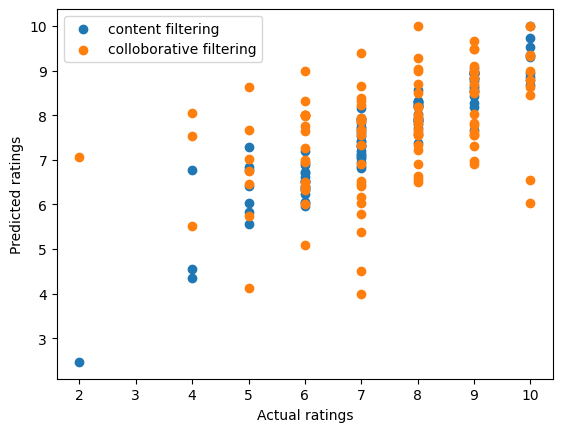

In [89]:
plt.scatter(test_sample.rating, test_sample.predicted_rating,label='content filtering')
plt.scatter(test_sample.rating, test_sample.predicted_rating_collab, label='colloborative filtering')
plt.ylabel('Predicted ratings')
plt.xlabel('Actual ratings')
plt.legend()
plt.show()

In [97]:
print('rmse_content: ' +str(np.round(np.mean(rmse_content),2)))
print('time_content: ' +str(np.round(np.mean(time_content),2)))
print('rmse_collab: ' +str(np.round(np.mean(rmse_collab),2)))
print('time_collab: ' +str(np.round(np.mean(time_collab),2)))


rmse_content: 0.69
time_content: 0.08
rmse_collab: 1.41
time_collab: 2.05


In [92]:
mse = root_mean_squared_error(test_sample['rating'], test_sample['predicted_rating'])
print(f"Mean Squared Error - Content Filtering: {mse}")
mse = root_mean_squared_error(test_sample['rating'], test_sample['predicted_rating_collab'])
print(f"Mean Squared Error - Collobarative Filtering: {mse}")

Mean Squared Error - Content Filtering: 0.7080400996130707
Mean Squared Error - Collobarative Filtering: 1.5755378788351824


Include time element as well, give an approximation for how long content and collobartive will run in streamlit

Content Filtering clearly performances better 

## 8. Streamlit

The streamlit app has two pages:
- **Information**: this page contains a description of the filtering methods and their performance metrics on our data.
- **Prediction**: this is where we predict the ratings for the users with option of choosing between content or collaborative based filtering
  
Below we compress the data used for the app given that it is quite large to load in github

In [98]:
import os 
path = os.getcwd()

Need to reduce the size of the utility matrix for streamlit 

In [99]:
#training data
df = pd.read_csv("test.csv", index_col=False)
df.shape

(633686, 2)

In [100]:
df = pd.merge(df, anime[['anime_id','name']], on = 'anime_id', how ='left')
df = df.dropna() 
df = df.reset_index(drop=True) 

In [101]:
sample = df.sample(20)
sample = sample.reset_index(drop=True)
final_sample = df[df.user_id.isin(sample.user_id)]
final_sample.shape
final_sample= final_sample.reset_index(drop=True) 
final_sample.head()

,user_id,anime_id,name
0,47724,167,Scrapped Princess
1,72786,16011,Tokyo Ravens
2,22706,9548,Alps no Shoujo Heidi: Alm no Yama-hen
3,67775,1210,NHK ni Youkoso!
4,47724,28297,Ore Monogatari!!


In [102]:
sample.to_csv(path + '/Streamlit/sample.csv', index=False)
sample = pd.read_csv(path + '/Streamlit/sample.csv')
sample.head()
sample.shape

(20, 3)

In [103]:
data = train_shrinked[(train_shrinked.user_id.isin(final_sample.user_id)) | (train_shrinked.anime_id.isin(final_sample.anime_id))]
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts  >= 100].index
data = data[data['user_id'].isin(active_users)]
data= data.reset_index(drop=True) 
#data.head()
data.shape

(312637, 4)

In [104]:
data.to_csv(path + '/Streamlit/data.csv', index=False)
data = pd.read_csv(path + '/Streamlit/data.csv')

In [105]:
util_matrix = data.pivot_table(index=['user_id'], 
                                       columns=['name'],
                                       values='rating') 
util_matrix.shape

(2343, 2330)

In [106]:
# Normalize each row (a given user's ratings) of the utility matrix
import scipy as sp
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
# Fill Nan values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [107]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(util_matrix_sparse.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_norm.columns, 
                           columns = util_matrix_norm.columns)

# Review a small portion of the constructed similarity matrix  
user_sim_df[:5]

user_id,5,17,210,226,248,271,294,392,446,478,530,540,553,661,741,771,784,786,813,814,943,946,958,1019,1058,1103,1132,1145,1176,1191,1254,1287,1344,1366,1396,1456,1497,1501,1504,1522,1530,1549,1570,1620,1689,1842,1853,1938,1963,1984,...,71491,71537,71610,71655,71790,71792,71796,71854,71893,71943,71984,71999,72007,72021,72060,72107,72264,72516,72610,72630,72646,72759,72786,72787,72814,72997,73070,73075,73099,73114,73132,73135,73153,73159,73162,73234,73286,73288,73329,73340,73346,73356,73362,73378,73379,73380,73395,73417,73499,73502
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1.000000,0.205444,0.060457,-0.045223,0.070952,0.063008,0.038004,0.198583,0.024716,0.098921,0.054060,0.079307,0.107336,0.096116,0.097289,0.247935,0.184750,0.126539,0.248379,0.166766,0.069591,0.150446,0.063707,0.219213,-0.029621,0.266826,0.084479,0.178804,0.268895,0.132761,-0.018172,0.062710,0.106974,0.105267,0.129404,0.094854,0.115333,0.104756,0.137675,0.075473,0.109593,0.080809,0.107038,0.016020,0.126819,0.140003,0.043214,0.281477,0.300466,0.145965,...,0.011269,0.118498,0.141649,0.150645,0.125044,0.280987,0.123099,0.105435,0.219929,0.123973,0.224628,0.184925,0.151426,0.127192,0.097892,0.142347,0.137129,0.199089,0.118762,0.218303,0.220391,0.057654,0.090471,0.229163,0.263012,0.221194,-0.071673,0.085479,0.242495,-0.014159,0.023949,0.189451,0.106823,-0.021248,0.184591,0.017227,0.092557,0.121236,0.184542,0.295112,0.049692,0.100662,0.030573,0.254557,0.177423,0.079666,0.248069,0.043493,0.173326,0.072769
17,0.205444,1.000000,0.033693,0.041770,0.179816,0.060072,0.164390,0.151319,0.114066,0.056909,0.147147,0.115939,0.143079,0.154384,0.248354,0.347401,0.159409,0.170213,0.210638,0.302127,0.133173,0.077657,0.133094,0.168823,0.017551,0.162128,-0.051896,0.214084,0.190911,0.042909,0.029145,0.045850,0.131828,0.036173,0.128404,0.116040,0.179254,0.148257,0.227638,0.188674,0.005352,-0.006686,0.218977,0.088701,-0.059773,0.215101,0.154938,0.164427,0.237517,0.084065,...,0.207586,0.176423,0.093297,0.147410,0.161098,0.144345,0.079945,0.266957,0.249499,0.088321,0.097140,0.194611,0.086434,0.122941,0.132273,0.176014,0.144676,0.205460,0.213129,0.131680,0.155142,0.039667,0.088524,0.171990,0.166843,0.109026,0.023589,0.156776,0.213724,-0.011113,0.058799,0.225038,0.147319,0.150861,0.137195,0.170949,0.116671,0.146564,0.059171,0.315022,0.133434,0.075358,0.105368,0.203682,0.170827,0.214713,0.125272,0.128936,0.172277,0.097400
210,0.060457,0.033693,1.000000,-0.020011,0.075732,0.069645,0.103083,0.058513,0.038427,0.128633,0.060884,0.192640,0.095803,0.131121,0.098453,0.128603,-0.053298,0.216068,0.082695,0.047878,0.213073,0.045889,0.048326,0.140066,0.218892,0.073726,-0.014756,0.086064,0.111761,0.030227,0.015695,0.171827,0.138774,0.048923,-0.015460,0.128888,0.172534,0.032779,0.143171,0.156900,-0.041754,0.098043,-0.017353,0.167407,0.050867,0.155764,0.257865,0.230574,0.165052,-0.041970,...,0.089839,0.117959,0.038078,0.063272,0.142880,0.053202,0.160722,0.100427,0.130936,0.179137,0.152726,0.046197,0.097782,0.113306,0.110483,0.189733,0.022378,0.074798,0.149997,0.108654,0.155553,0.069721,0.014638,0.196845,0.270036,0.251251,-0.020934,0.114497,0.124782,-0.037520,0.033312,0.066611,0.000007,0.061287,0.120051,0.121852,0.162829,0.067570,0.159764,0.104977,0.116555,0.191637,0.063365,0.194276,0.097090,0.093086,0.102861,0.074911,0.133911,0.133031
226,-0.045223,0.041770,-0.020011,1.000000,-0.041052,0.019387,0.033363,-0.139285,-0.100880,-0.118258,-0.168684,0.053008,0.051048,-0.003061,-0.062924,-0.014153,-0.096899,-0.029572,-0.031236,-0.112713,0.092117,0.018983,-0.081096,-0.015802,-0.098083,-0.076455,-0.071009,0.018196,-0.002368,-0.083525,-0.076896,0.154521,0.015440,0.042610,-0.086600,-0.104991,0.010630,-0.080989,-0.030949,-0.007560,0.008314,0.043142,0.039518,0.083790,0.043353,-0.108382,-0.126806,-0.014051,-0.058062,-0.043468,...,-0.005533,0.078269,-0.016779,-0.077121,-0.018024,0.001357,0.083053,0.030431,0.035468,-0.016800,0.007396,0.024915,-0.021292,-0

In [108]:
import joblib
user_sim_df.to_pickle(path + '\\Streamlit\\user_sim_df.pkl')
user_sim_df = pd.read_pickle(path + '\\Streamlit\\user_sim_df.pkl')
user_sim_df.head()

user_id,5,17,210,226,248,271,294,392,446,478,530,540,553,661,741,771,784,786,813,814,943,946,958,1019,1058,1103,1132,1145,1176,1191,1254,1287,1344,1366,1396,1456,1497,1501,1504,1522,1530,1549,1570,1620,1689,1842,1853,1938,1963,1984,...,71491,71537,71610,71655,71790,71792,71796,71854,71893,71943,71984,71999,72007,72021,72060,72107,72264,72516,72610,72630,72646,72759,72786,72787,72814,72997,73070,73075,73099,73114,73132,73135,73153,73159,73162,73234,73286,73288,73329,73340,73346,73356,73362,73378,73379,73380,73395,73417,73499,73502
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,1.000000,0.205444,0.060457,-0.045223,0.070952,0.063008,0.038004,0.198583,0.024716,0.098921,0.054060,0.079307,0.107336,0.096116,0.097289,0.247935,0.184750,0.126539,0.248379,0.166766,0.069591,0.150446,0.063707,0.219213,-0.029621,0.266826,0.084479,0.178804,0.268895,0.132761,-0.018172,0.062710,0.106974,0.105267,0.129404,0.094854,0.115333,0.104756,0.137675,0.075473,0.109593,0.080809,0.107038,0.016020,0.126819,0.140003,0.043214,0.281477,0.300466,0.145965,...,0.011269,0.118498,0.141649,0.150645,0.125044,0.280987,0.123099,0.105435,0.219929,0.123973,0.224628,0.184925,0.151426,0.127192,0.097892,0.142347,0.137129,0.199089,0.118762,0.218303,0.220391,0.057654,0.090471,0.229163,0.263012,0.221194,-0.071673,0.085479,0.242495,-0.014159,0.023949,0.189451,0.106823,-0.021248,0.184591,0.017227,0.092557,0.121236,0.184542,0.295112,0.049692,0.100662,0.030573,0.254557,0.177423,0.079666,0.248069,0.043493,0.173326,0.072769
17,0.205444,1.000000,0.033693,0.041770,0.179816,0.060072,0.164390,0.151319,0.114066,0.056909,0.147147,0.115939,0.143079,0.154384,0.248354,0.347401,0.159409,0.170213,0.210638,0.302127,0.133173,0.077657,0.133094,0.168823,0.017551,0.162128,-0.051896,0.214084,0.190911,0.042909,0.029145,0.045850,0.131828,0.036173,0.128404,0.116040,0.179254,0.148257,0.227638,0.188674,0.005352,-0.006686,0.218977,0.088701,-0.059773,0.215101,0.154938,0.164427,0.237517,0.084065,...,0.207586,0.176423,0.093297,0.147410,0.161098,0.144345,0.079945,0.266957,0.249499,0.088321,0.097140,0.194611,0.086434,0.122941,0.132273,0.176014,0.144676,0.205460,0.213129,0.131680,0.155142,0.039667,0.088524,0.171990,0.166843,0.109026,0.023589,0.156776,0.213724,-0.011113,0.058799,0.225038,0.147319,0.150861,0.137195,0.170949,0.116671,0.146564,0.059171,0.315022,0.133434,0.075358,0.105368,0.203682,0.170827,0.214713,0.125272,0.128936,0.172277,0.097400
210,0.060457,0.033693,1.000000,-0.020011,0.075732,0.069645,0.103083,0.058513,0.038427,0.128633,0.060884,0.192640,0.095803,0.131121,0.098453,0.128603,-0.053298,0.216068,0.082695,0.047878,0.213073,0.045889,0.048326,0.140066,0.218892,0.073726,-0.014756,0.086064,0.111761,0.030227,0.015695,0.171827,0.138774,0.048923,-0.015460,0.128888,0.172534,0.032779,0.143171,0.156900,-0.041754,0.098043,-0.017353,0.167407,0.050867,0.155764,0.257865,0.230574,0.165052,-0.041970,...,0.089839,0.117959,0.038078,0.063272,0.142880,0.053202,0.160722,0.100427,0.130936,0.179137,0.152726,0.046197,0.097782,0.113306,0.110483,0.189733,0.022378,0.074798,0.149997,0.108654,0.155553,0.069721,0.014638,0.196845,0.270036,0.251251,-0.020934,0.114497,0.124782,-0.037520,0.033312,0.066611,0.000007,0.061287,0.120051,0.121852,0.162829,0.067570,0.159764,0.104977,0.116555,0.191637,0.063365,0.194276,0.097090,0.093086,0.102861,0.074911,0.133911,0.133031
226,-0.045223,0.041770,-0.020011,1.000000,-0.041052,0.019387,0.033363,-0.139285,-0.100880,-0.118258,-0.168684,0.053008,0.051048,-0.003061,-0.062924,-0.014153,-0.096899,-0.029572,-0.031236,-0.112713,0.092117,0.018983,-0.081096,-0.015802,-0.098083,-0.076455,-0.071009,0.018196,-0.002368,-0.083525,-0.076896,0.154521,0.015440,0.042610,-0.086600,-0.104991,0.010630,-0.080989,-0.030949,-0.007560,0.008314,0.043142,0.039518,0.083790,0.043353,-0.108382,-0.126806,-0.014051,-0.058062,-0.043468,...,-0.005533,0.078269,-0.016779,-0.077121,-0.018024,0.001357,0.083053,0.030431,0.035468,-0.016800,0.007396,0.024915,-0.021292,-0

In [109]:
util_matrix.to_pickle(path + '\\Streamlit\\util_matrix.pkl')
util_matrix = pd.read_pickle(path + '\\Streamlit\\util_matrix.pkl')
util_matrix.head()

name,&quot;Bungaku Shoujo&quot; Movie,.hack//Gift,.hack//Liminality,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Unison,07-Ghost,11eyes,30-sai no Hoken Taiiku,91 Days,91 Days Recap,A Kite,A-Channel,A-Channel+smile,A-Channel: +A-Channel,AIKa,AKB0048,AKB0048: Next Stage,Aa! Megami-sama!,Aa! Megami-sama! (2011),Aa! Megami-sama! (TV),Aa! Megami-sama! (TV) Specials,Aa! Megami-sama!: Sorezore no Tsubasa,Aa! Megami-sama!: Sorezore no Tsubasa Specials,Abenobashi Mahou☆Shoutengai,Absolute Duo,Accel World,Accel World EX,Accel World: Acchel World.,Acchi Kocchi (TV),Acchi Kocchi (TV): Place=Princess,Afro Samurai,Afro Samurai Movie,Afro Samurai: Resurrection,After War Gundam X,After... The Animation,Ai no Kusabi (2012),Air,Air Gear,Air Gear Special,Air Gear: Kuro no Hane to Nemuri no Mori - Break on the Sky,Air Movie,Air in Summer,Aishiteruze Baby★★,Aiura,Ajin,Akagami no Shirayuki-hime,Akagami no Shirayuki-hime 2nd Season,"Akagami no Shirayuki-hime: Nandemonai Takaramono, Kono Page",...,"Yuru Yuri: Doushite, Tomaranai, Tokimeki, Dokidoki, Paradox, Eternal",Yuru Yuri♪♪,Yuusha ni Narenakatta Ore wa Shibushibu Shuushoku wo Ketsui Shimashita.,Yuusha-Ou GaoGaiGar,Yuusha-Ou GaoGaiGar Final,Yuu☆Yuu☆Hakusho,Yuyushiki,Yu☆Gi☆Oh!,Yu☆Gi☆Oh! (1999),Yu☆Gi☆Oh! 5D&#039;s,Yu☆Gi☆Oh! 5D&#039;s: Shinkasuru Kettou! Stardust vs. Red Demon&#039;s,Yu☆Gi☆Oh! Duel Monsters,Yu☆Gi☆Oh! Duel Monsters: Battle City Special,Yu☆Gi☆Oh!: Chou Yuugou! Toki wo Koeta Kizuna,Yu☆Gi☆Oh!: Duel Monsters GX,Yu☆Gi☆Oh!: Hikari no Pyramid,Zan Sayonara Zetsubou Sensei,Zan Sayonara Zetsubou Sensei Bangaichi,Zankyou no Terror,Zegapain,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zero no Tsukaima: Princesses no Rondo - Yuuwaku no Sunahama,Zero no Tsukaima: Princesses no Rondo Picture Drama,Zetman,Zetsuen no Tempest,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,eX-Driver,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [110]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members,tags
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"Kimi no Na wa., Drama, Romance, School, Supern..."
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"Fullmetal Alchemist: Brotherhood, Action, Adve..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"Gintama°, Action, Comedy, Historical, Parody, ..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"Steins;Gate, Sci-Fi, Thriller"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,"Gintama&#039;, Action, Comedy, Historical, Par..."


In [111]:
anime_shrinked = anime[anime.anime_id.isin(data.anime_id)]
anime_shrinked = anime_shrinked.reset_index(drop=True) 
anime_shrinked.shape

(2330, 8)

In [112]:
indices = pd.Series(anime_shrinked.index, index=anime_shrinked['name'])
indices.to_pickle(path + '\\Streamlit\\indices.pkl')
indices = pd.read_pickle(path + '\\Streamlit\\indices.pkl')
indices.head()

name
Kimi no Na wa.                      0
Fullmetal Alchemist: Brotherhood    1
Gintama°                            2
Steins;Gate                         3
Gintama&#039;                       4
dtype: int64

In [113]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns 
tf_authTags_matrix = tf.fit_transform(anime_shrinked['tags'])

In [114]:
cosine_sim_Tags = cosine_similarity(tf_authTags_matrix, 
                                        tf_authTags_matrix)
print (cosine_sim_Tags.shape)

(2330, 2330)


In [115]:
cosine_sim_Tags = pd.DataFrame(cosine_sim_Tags)

In [116]:
cosine_sim_Tags.to_pickle(path + '\\Streamlit\\cosine_sim_Tags.pkl')
cosine_sim_Tags = pd.read_pickle(path + '\\Streamlit\\cosine_sim_Tags.pkl')
cosine_sim_Tags.head()
np.array(cosine_sim_Tags).shape

(2330, 2330)

Link to streamlit: [here](https://vuyiswak-2401-ptds-unsupervised-learni-streamlitbase-app-crflhp.streamlit.app/)

## 9. Conclusion

> - Content Based Filtering is by far superior in terms of accuracy of predicting ratings and execution time.